In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os 
import sys
sys.path.append('../')
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular
from src.finance_ml.data_preparation.data_preparation import DataLoader
from src.finance_ml.data_preparation.asset_class import Asset
from src.finance_ml.feature_importance.ensemble import mdi,mda,shap_func

# Importing cryptocurrency time series for model creation

i. DataLoader is an instance for working with stock, crypto, etc. time series.

ii. Extracting the time series data for Bitcoin and Dogecoin from July 2021 to April 2022.

iii. Only the daily closing data is selected; intra-trade data will not be evaluated at the moment.


In [5]:
dataloader = DataLoader(time_index_col= 'DATE',keep_cols = ['VOLUME','OPEN', 'CLOSE', 'LOW', 'TRANSACTIONS'])

data = dataloader.load_dataset({'DOGE':'../data/cryptos/DOGEUSD_2020-04-07_2022-04-06.parquet'})
asset1 = Asset(ticker="GOLD", data= data, index_name=dataloader.time_index_col)
data = dataloader.load_dataset({'BITCOINS':'../data/cryptos/BTCUSD_2020-04-07_2022-04-06.parquet'})
asset2 = Asset(ticker="BITCOINS", data = data, index_name=dataloader.time_index_col)

doge = asset1.data
bitcoin = asset2.data

doge['DATE_TRUNC'] = doge.index.floor('D')
bitcoin['DATE_TRUNC'] = bitcoin.index.floor('D')

doge = doge.groupby(['DATE_TRUNC']).agg({'DOGE_CLOSE':'last','DOGE_TRANSACTIONS':'sum'}).reset_index()
bitcoin = bitcoin.groupby(['DATE_TRUNC']).agg({'BITCOINS_CLOSE':'last','BITCOINS_TRANSACTIONS':'sum'}).reset_index()

doge = doge[doge['DATE_TRUNC']>dt.datetime(2021,7,1)]
bitcoin = bitcoin[bitcoin['DATE_TRUNC']>dt.datetime(2021,7,1)]

In [6]:
bitcoin

,DATE_TRUNC,BITCOINS_CLOSE,BITCOINS_TRANSACTIONS
451,2021-07-02,33805.02,387342
452,2021-07-03,34688.30,259129
453,2021-07-04,35284.05,243802
454,2021-07-05,33697.78,356321
455,2021-07-06,34225.73,379318
...,...,...,...
724,2022-04-02,45826.27,543779
725,2022-04-03,46422.16,467177
726,2022-04-04,46596.83,573008
727,2022-04-05,45495.29,708331


For better comparison of the time series, the closing values of Dogecoin and Bitcoin are transformed into logarithmic returns to maintain the same scale and track the return of each from July 1, 2021.

Additionally, for future use in a model, lag variables of the returns have been created, specifically for one day, seven days, and 30 days. These variables will be analyzed to understand their importance in a Bitcoin trading model, aiming to achieve a positive return.

Returns represent the percentage change in the value of an asset over a specific period.
Returns are calculated based on the change in price from the beginning to the end of the period.
Returns can be expressed as simple returns or logarithmic returns.

This difference represents the daily percentage change in the closing prices.

Logarithmic returns have desirable statistical properties, including stationarity and additive behavior. They are often preferred over simple returns for financial time series analysis.

By using logarithmic returns, the model can better capture the percentage change in prices, making the data more amenable to linear modeling techniques
.
Lag variables help incorporate historical information into the analysis, allowing the model to consider past trends when making predictions.






In [7]:
doge['LOG_RETURNS'] = np.log(doge['DOGE_CLOSE']).diff()

doge['D-1_Log_Return'] = doge['LOG_RETURNS'].shift(1)
doge['D-7_Log_Return'] = doge['LOG_RETURNS'].shift(7)
doge['D-30_Log_Return'] = doge['LOG_RETURNS'].shift(30)

doge = doge[doge['D-30_Log_Return'].notnull()]

bitcoin['LOG_RETURNS'] = np.log(bitcoin['BITCOINS_CLOSE']).diff()

bitcoin['D-1_Log_Return'] = bitcoin['LOG_RETURNS'].shift(1)
bitcoin['D-7_Log_Return'] = bitcoin['LOG_RETURNS'].shift(7)
bitcoin['D-30_Log_Return'] = bitcoin['LOG_RETURNS'].shift(30)

bitcoin = bitcoin[bitcoin['D-30_Log_Return'].notnull()]

In the graph below, representing logarithmic returns, a common trend in Dogecoin and Bitcoin is noticeable. From November 2021, there is a downward trend in both, and from the second quarter of 2022, there is a recovery in returns.

Text(0.5, 1.0, 'Comparison of log return for Doge and Bitcoin')

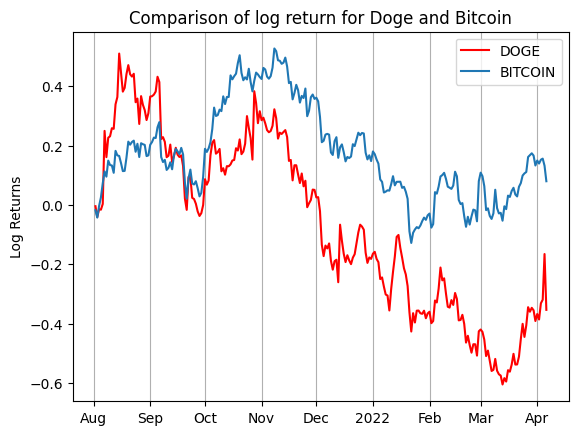

In [8]:
fig, ax1 = plt.subplots()

ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

a = ax1.plot(doge['DATE_TRUNC'],doge['LOG_RETURNS'].cumsum(),color='r')
b = ax1.plot(bitcoin['DATE_TRUNC'],bitcoin['LOG_RETURNS'].cumsum())

ax1.legend(a+b,['DOGE','BITCOIN'])
ax1.xaxis.grid()
ax1.set_ylabel('Log Returns')
ax1.set_title('Comparison of log return for Doge and Bitcoin')

In [9]:
doge = doge.rename(columns = {x:x+'_DOGE' for x in doge.columns if x in ['LOG_RETURNS','D-1_Log_Return','D-7_Log_Return','D-30_Log_Return']})
bitcoin = bitcoin.rename(columns = {x:x+'_BITCOIN' for x in bitcoin.columns if x in ['LOG_RETURNS','D-1_Log_Return','D-7_Log_Return','D-30_Log_Return']})

final = bitcoin.merge(doge,how = 'inner',on = ['DATE_TRUNC'],validate = '1:1')

final = final.sort_values('DATE_TRUNC')

final = final.drop(['DATE_TRUNC','BITCOINS_CLOSE','DOGE_TRANSACTIONS','BITCOINS_TRANSACTIONS','DOGE_CLOSE',],axis = 1)

It will be used to predict whether the return of Bitcoin on the next day will be positive or not, using information on the return from the last day, 7 days ago, and 30 days ago for both Bitcoin and Dogecoin. Additionally, a wildcard variable, the return of Dogecoin on the same day as the Bitcoin prediction, will be added. As seen previously, there is a correlation between both in the analyzed period, so it will be used to assess the importance metrics as it is a prominent variable.

In [10]:
final

,LOG_RETURNS_BITCOIN,D-1_Log_Return_BITCOIN,D-7_Log_Return_BITCOIN,D-30_Log_Return_BITCOIN,LOG_RETURNS_DOGE,D-1_Log_Return_DOGE,D-7_Log_Return_DOGE,D-30_Log_Return_DOGE
0,-0.018050,-0.039907,0.050485,0.025793,-0.004415,-0.017468,0.028858,0.005288
1,-0.024848,-0.018050,0.058306,0.017029,-0.036652,-0.004415,0.009761,0.000365
2,0.039304,-0.024848,0.013456,-0.045999,0.026770,-0.036652,0.000000,-0.066609
3,0.028939,0.039304,-0.000877,0.015546,-0.001988,0.026770,-0.004869,0.015057
4,0.047308,0.028939,0.053884,-0.010002,0.019461,-0.001988,0.018855,-0.044976
...,...,...,...,...,...,...,...,...
242,-0.010205,0.016731,0.004671,-0.033623,-0.018559,0.023615,0.038956,-0.026027
243,0.012919,-0.010205,0.050577,-0.080844,0.054674,-0.018559,0.061273,-0.055482
244,0.003756,0.012919,0.006275,0.006005,0.012204,0.054674,-0.015321,0.018571
245,-0.023924,0.003756,0.006244,-0.025561,0.153958,0.012204,0.013184,-0.035006


The trained model will be a RandomForest from the sklearn library. The model will be trained on 80% of the dataset and evaluated on the subsequent 20% future time points of the dataset. We will consider a return as positive if it is greater than 1% from one day to the next; specifically, it will be labeled as 1 if the return is greater than 1% and 0 otherwise.

In [11]:
clf = RandomForestClassifier()

test_ratio = 0.2

cut_test = int(len(final)*(1-test_ratio))

y = (np.exp(final['LOG_RETURNS_BITCOIN']) > 1.01)*1
X = final[[x for x in final.columns if x not in ['LOG_RETURNS_BITCOIN']]]

y_train = y.iloc[:cut_test].reset_index(drop=True)
y_test = y.iloc[cut_test:].reset_index(drop=True)

X_train = X.iloc[:cut_test].reset_index(drop=True)
X_test = X.iloc[cut_test:].reset_index(drop=True)

clf.fit(X_train,y_train)

RandomForestClassifier()

In [12]:
impurity = mdi(clf,X.columns)
accuracy = mda(clf,X_train,y_train)

shap_f = shap_func(clf,X_train,list(X_train.columns))

impurity['TYPE'] = 'MDI'
accuracy['TYPE'] = 'MDA'
shap_f['TYPE'] = 'SHAP'

eval_feat = pd.concat([impurity,accuracy,shap_f])

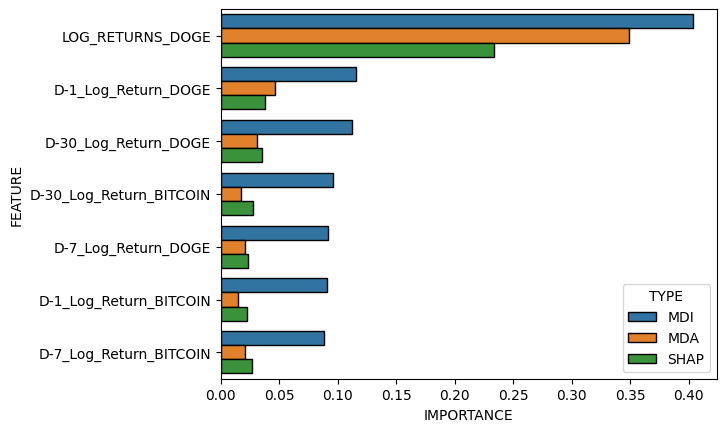

In [13]:
import seaborn as sns
sns.barplot(data = eval_feat , x = 'IMPORTANCE',y = 'FEATURE',hue = 'TYPE',linewidth=1, edgecolor="0")
plt.show()

As mentioned earlier, in all three methods, the return of Dogecoin on the same day as the prediction is the variable that most impacted the model in all three methodologies. However, some variables differ; for example, the second most important variable for MDI was the return of Dogecoin 30 days ago, while for MDA and SHAP, it was the return of Dogecoin on the last day. Interestingly, the lagged return variables for Dogecoin demonstrated greater importance than those of the cryptocurrency being predicted, and this pattern is consistent across all metrics for the analyzed period.

In [14]:
impurity = impurity.sort_values('IMPORTANCE',ascending= False)[['FEATURE']].reset_index(drop=True)

impurity = impurity.rename(columns={'FEATURE':'MDI'})

accuracy = accuracy.sort_values('IMPORTANCE',ascending= False)[['FEATURE']].reset_index(drop=True)

accuracy = accuracy.rename(columns={'FEATURE':'MDA'})

shap_f = shap_f.sort_values('IMPORTANCE',ascending= False)[['FEATURE']].reset_index(drop=True)

shap_f = shap_f.rename(columns={'FEATURE':'SHAP'})

top = pd.concat([impurity,accuracy,shap_f],axis=1)

top['RANK'] = range(1,len(top)+1)

top[['RANK','MDI','MDA','SHAP']]


,RANK,MDI,MDA,SHAP
0,1,LOG_RETURNS_DOGE,LOG_RETURNS_DOGE,LOG_RETURNS_DOGE
1,2,D-1_Log_Return_DOGE,D-1_Log_Return_DOGE,D-1_Log_Return_DOGE
2,3,D-30_Log_Return_DOGE,D-30_Log_Return_DOGE,D-30_Log_Return_DOGE
3,4,D-30_Log_Return_BITCOIN,D-7_Log_Return_BITCOIN,D-30_Log_Return_BITCOIN
4,5,D-7_Log_Return_DOGE,D-7_Log_Return_DOGE,D-7_Log_Return_BITCOIN
5,6,D-1_Log_Return_BITCOIN,D-30_Log_Return_BITCOIN,D-7_Log_Return_DOGE
6,7,D-7_Log_Return_BITCOIN,D-1_Log_Return_BITCOIN,D-1_Log_Return_BITCOIN


### LIME
LIME is a model-agnostic technique that provides local interpretability for complex machine learning models. The goal is to explain the prediction of the classifier for a specific data point in terms of the most important features.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


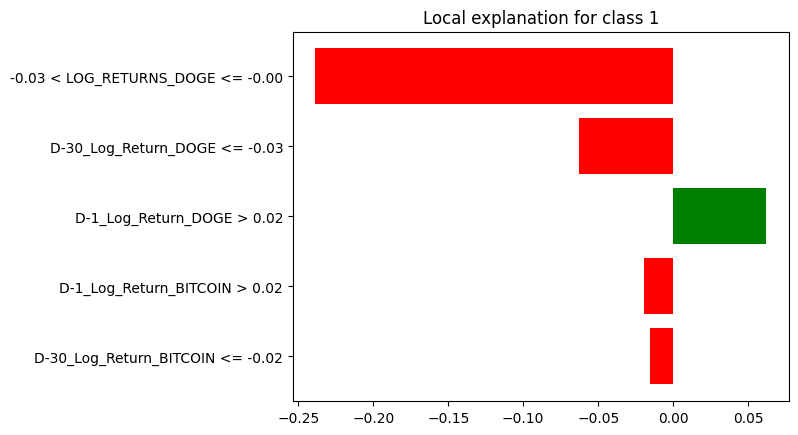

In [16]:
# Define a function to predict using the RandomForestClassifier
def predict_fn(data):
    return clf.predict_proba(data)[:, 1]

# Select a specific data point for which you want to generate the LIME explanation
selected_data_point = X_test.iloc[0].values.reshape(1, -1)  # Choose the first data point as an example
feature_names = X_train.columns.tolist()
if hasattr(clf, "predict_proba"):
    # Create a LIME explainer
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='classification', feature_names=feature_names)

    # Generate an explanation for the selected data point
    explanation = explainer.explain_instance(selected_data_point.flatten(), clf.predict_proba, num_features=5)

    # Plot the LIME explanation
    explanation.as_pyplot_figure()
    #plt.savefig("Lime.png")
else:
    print("Classifier does not support probability scores.")